# Loading Image Dataset

`Ascend` `GPU` `CPU` `Data Preparation`

[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindspore/programming_guide/source_en/load_dataset_image.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_notebook_en.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/programming_guide/en/mindspore_load_dataset_image.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_modelarts_en.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9tYXN0ZXIvcHJvZ3JhbW1pbmdfZ3VpZGUvZW4vbWluZHNwb3JlX2xvYWRfZGF0YXNldF9pbWFnZS5pcHluYg==&imageid=65f636a0-56cf-49df-b941-7d2a07ba8c8c)

## Overview

In computer vision training tasks, it is often difficult to read the entire dataset directly into memory due to memory capacity. The `mindspore.dataset` module provided by MindSpore enables users to customize their data fetching strategy from disk. At the same time, data processing and data augmentation operators are applied to the data. Pipelined data processing produces a continuous flow of data to the training network, improving overall performance.

In addition, MindSpore supports data loading in distributed scenarios. Users can define the number of shards while loading. For more details, see [Loading the Dataset in Data Parallel Mode](https://www.mindspore.cn/docs/programming_guide/en/master/distributed_training_ascend.html#loading-the-dataset-in-data-parallel-mode).

This tutorial uses the [MNIST dataset [1]](#references) as an example to demonstrate how to load and process image data using MindSpore.

## Preparations

### Importing Module

This module provides APIs to load and process data sets.

In [1]:
import mindspore.dataset as ds

### Downloading Dataset

put the dataset in the path `./datasets/MNIST_Data`, the directory structure is as follows:

```text
./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```
Run the following command in jupyter notebook to download the training images and labels of the MNIST dataset:

In [2]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte --no-check-certificate

./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte

2 directories, 4 files


## Loading Dataset

MindSpore supports loading common datasets in the field of image processing that come in a variety of on-disk formats. Users can also implement custom dataset class to load customized data. For the detailed loading method of various datasets, please refer to the [Loading Dataset](https://www.mindspore.cn/docs/programming_guide/en/master/dataset_loading.html) in the programming guide.

The following tutorial shows how to load the MNIST dataset using the `MnistDataset` in the `mindspore.dataset` module.

1. Configure the dataset directory and create the `MnistDataset`.

In [3]:
DATA_DIR = './datasets/MNIST_Data/train'
mnist_dataset = ds.MnistDataset(DATA_DIR, num_samples=6, shuffle=False)

2. Create an iterator then obtain data through the iterator.

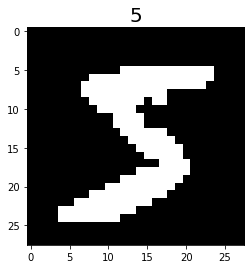

In [4]:
    import matplotlib.pyplot as plt

    mnist_it = mnist_dataset.create_dict_iterator()
    data = next(mnist_it)
    plt.imshow(data['image'].asnumpy().squeeze(), cmap=plt.cm.gray)
    plt.title(data['label'].asnumpy(), fontsize=20)
    plt.show()

In addition, users can pass in a `sampler` parameter to specify the sampling process during dataset loading. For the data samplers supported by MindSpore and their detailed usage methods, please refer to the programming guide [sampler](https://www.mindspore.cn/docs/programming_guide/en/master/sampler.html).

## Processing Data

For the data processing operators currently supported by MindSpore and their detailed usage methods, please refer to the [Processing Data](https://www.mindspore.cn/docs/programming_guide/en/master/pipeline.html) in the programming guide.

The following tutorial demonstrates how to construct a pipeline and perform operations such as `shuffle`, `batch` and `repeat` on the MNIST dataset.

In [5]:
for data in mnist_dataset.create_dict_iterator():
    print(data['label'])

5
0
4
1
9
2


1. Shuffle the dataset.

In [6]:
    ds.config.set_seed(58)
    ds1 = mnist_dataset.shuffle(buffer_size=6)

    print('after shuffle: ')
    for data in ds1.create_dict_iterator():
        print(data['label'])

after shuffle: 
4
2
1
0
5
9


2. Add `batch` after `shuffle`.

In [7]:
    ds2 = ds1.batch(batch_size=2)

    print('after batch: ')
    for data in ds2.create_dict_iterator():
        print(data['label'])

after batch: 
[4 2]
[1 0]
[5 9]


3. Add `repeat` after `batch`.

In [8]:
    ds3 = ds2.repeat(count=2)

    print('after repeat: ')
    for data in ds3.create_dict_iterator():
        print(data['label'])

after repeat: 
[4 2]
[1 0]
[5 9]
[2 4]
[0 9]
[1 5]


The results show the dataset is repeated, and the order of the replica is different from that of the first copy. Having `repeat` in the pipeline results in the execution of repeated operations defined in the entire pipeline, instead of simply copying the current dataset. So the order of the replica is different from that of the first copy after `shuffle`.

In addition, you need to pay attention to the sequence of repeat and batch operations: 1) Usually the batch operation is performed before the repeat operation. 2) If the batch operation is performed after the repeat operation, the batch operation will batch the data between the two epochs together (in some cases, swapping the order of batch and repeat will cause the number of batches contained in the dataset to be inconsistent, because the batch operator initialization contains the `drop_reminder` parameter, which is set to False by default).

## Augmentation

For the data augmentation operators supported by MindSpore and their detailed usage methods, please refer to the programming guide [Data Augmentation](https://www.mindspore.cn/docs/programming_guide/en/master/augmentation.html).

The following tutorial demonstrates how to use the `c_transforms` module to augment data in the MNIST dataset.

1. Import related modules and load the dataset.

In [9]:
    from mindspore.dataset.vision import Inter
    import mindspore.dataset.vision.c_transforms as transforms

    mnist_dataset = ds.MnistDataset(DATA_DIR, num_samples=6, shuffle=False)

2. Define augmentation operators and perform the `Resize` and `RandomCrop` operations on images in the dataset.

In [10]:
    resize_op = transforms.Resize(size=(200,200), interpolation=Inter.LINEAR)
    crop_op = transforms.RandomCrop(150)
    transforms_list = [resize_op, crop_op]
    ds4 = mnist_dataset.map(operations=transforms_list,input_columns='image')

3. Visualize the result of augmentation.

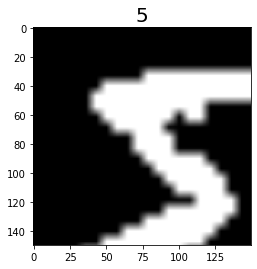

In [11]:
    mnist_it = ds4.create_dict_iterator()
    data = next(mnist_it)
    plt.imshow(data['image'].asnumpy().squeeze(), cmap=plt.cm.gray)
    plt.title(data['label'].asnumpy(), fontsize=20)
    plt.show()

The original image is scaled up then randomly cropped to 150 x 150.

## References

[1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).